In [1]:
from typing import List, Union, TextIO
import os
import subprocess
import tempfile

import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import rdMolAlign

from molclub.compute import gfnff, gfnxtb
from molclub.conf_tools import etkdg, crest
from molclub.conf_tools.conf_utils import order_confs, boltzmann_pop, prune, rmsd_matrix
from molclub import visualize

In [3]:
# smi = 'COC1=C(F)C=CC2=C1C=C(N2)C(=O)N(C)C1=CN=C(O1)C#N'
smi = 'OCCO'
mol = Chem.MolFromSmiles(smi)
etkdg_mols = etkdg.generate_conformers(mol, num_confs='auto', num_threads=4)
etkdg_mols, etkdg_energies = zip(*[gfnff.opt(mol, num_threads=4) for mol in etkdg_mols])
etkdg_mols, etkdg_energies = list(etkdg_mols), list(etkdg_energies)
etkdg_mols, etkdg_energies = prune(etkdg_mols, etkdg_energies)
etkdg_mols, etkdg_energies = order_confs(etkdg_mols, etkdg_energies)
len(etkdg_mols)

3

In [4]:
boltzmann_pop(etkdg_energies)

[0.5071679179384367, 0.49283208206156315]

In [5]:
params = crest.Parameters(search_intensity='faster', num_threads=4)
crest_mols = crest.generate_conformers(etkdg_mols[0], crest_params=params)
crest_mols, crest_energies = zip(*[gfnxtb.opt(mol, num_threads=4) for mol in crest_mols])
crest_mols, crest_energies = order_confs(crest_mols, crest_energies)
len(crest_mols)

3

In [16]:
for mol in etkdg_mols:
    mol.SetProp('gen', 'etkdg')
for mol in crest_mols:
    mol.SetProp('gen', 'crest')

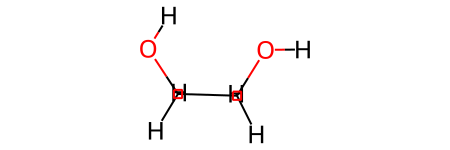

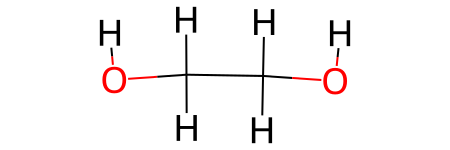

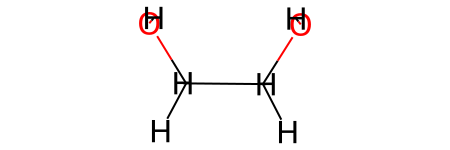

In [7]:
for mol in crest_mols:
    display(mol)

In [96]:
all_mols = etkdg_mols + crest_mols
all_energies = etkdg_energies + crest_energies
all_mols, all_energies = order_confs(all_mols, all_energies)
all_boltz = boltzmann_pop(all_energies)

In [97]:
# for etkdg
remove_idx = []
for i, mol in enumerate(all_mols):
    if mol.GetProp('gen') != 'etkdg':
        keep = True
        for q_mol in etkdg_mols:
            if rdMolAlign.GetBestRMS(Chem.RemoveHs(q_mol), Chem.RemoveHs(mol)) < 0.125:
                keep = False
        if not keep:
            remove_idx.append(i)

print(remove_idx)

for i in reversed(remove_idx):
    all_mols.pop(i)
    all_energies.pop(i)

[0, 2, 6, 7, 10, 12, 16, 17]


In [98]:
all_boltz = boltzmann_pop(all_energies)
all_boltz

[0.15310935926039232,
 0.15051944138982584,
 0.1454927995787803,
 0.14539294807350028,
 0.09047916556950147,
 0.09010916002010914,
 0.08900710770392498,
 0.08722065068127059,
 0.048669367722695075]

In [100]:
for mol in all_mols:
    print(mol.GetProp('gen'))

etkdg
etkdg
etkdg
etkdg
crest
crest
etkdg
etkdg
crest
etkdg


In [3]:
def get_rms_matrix(mols):
    mols_no_h = [Chem.RemoveHs(mol) for mol in mols]
    rms_matrix = np.ndarray((len(mols_no_h), len(mols_no_h)))
    rms_matrix.fill(-1)
    for i, mol_1 in enumerate(mols_no_h):
        for j, mol_2 in enumerate(mols_no_h):
            if j >= i:
                rms = rdMolAlign.GetBestRMS(mol_1, mol_2)
                rms_matrix[i][j] = rms
    return pd.DataFrame(rms_matrix)

In [8]:
get_rms_matrix(etkdg_mols)

NameError: name 'get_rms_matrix' is not defined

In [5]:
print(len(etkdg_mols))
etkdg_mols = prune(etkdg_mols)
len(etkdg_mols)

9


6